In [1]:
from types import SimpleNamespace

import numpy as np
from scipy import optimize

import pandas as pd 
import matplotlib.pyplot as plt

class HouseholdSpecializationModelClass:

    def __init__(self):
        """ setup model """

        # a. create namespaces
        par = self.par = SimpleNamespace()
        sol = self.sol = SimpleNamespace()

        # b. preferences
        par.rho = 2.0
        par.nu = 0.001
        par.epsilon = 1.0
        par.omega = 0.5 

        # c. household production
        par.alpha = 0.5
        par.sigma = 1.0

        # d. wages
        par.wM = 1.0
        par.wF = 1.0
        par.wF_vec = np.linspace(0.8,1.2,5)

        # e. targets
        par.beta0_target = 0.4
        par.beta1_target = -0.1

        # f. solution
        sol.LM_vec = np.zeros(par.wF_vec.size)
        sol.HM_vec = np.zeros(par.wF_vec.size)
        sol.LF_vec = np.zeros(par.wF_vec.size)
        sol.HF_vec = np.zeros(par.wF_vec.size)

        sol.beta0 = np.nan
        sol.beta1 = np.nan

    def calc_utility(self,LM,HM,LF,HF):
        """ calculate utility """

        par = self.par
        sol = self.sol

        # a. consumption of market goods
        C = par.wM*LM + par.wF*LF

        # b. home production
        if par.sigma == 0:
            H = np.min(LM,HM)
        elif par.sigma == 1:
            H = HM**(1-par.alpha)*HF**par.alpha
        else:
            H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma) + par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))

        # c. total consumption utility
        Q = C**par.omega*H**(1-par.omega)
        utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)

        # d. disutlity of work
        epsilon_ = 1+1/par.epsilon
        TM = LM+HM
        TF = LF+HF
        disutility = par.nu*(TM**epsilon_/epsilon_+TF**epsilon_/epsilon_)
        
        return utility - disutility

    def solve_discrete(self,do_print=False):
        """ solve model discretely """
        
        par = self.par
        sol = self.sol
        opt = SimpleNamespace()
        
        # a. all possible choices
        x = np.linspace(0,24,49)
        LM,HM,LF,HF = np.meshgrid(x,x,x,x) # all combinations
    
        LM = LM.ravel() # vector
        HM = HM.ravel()
        LF = LF.ravel()
        HF = HF.ravel()

        # b. calculate utility
        u = self.calc_utility(LM,HM,LF,HF)
    
        # c. set to minus infinity if constraint is broken
        I = (LM+HM > 24) | (LF+HF > 24) # | is "or"
        u[I] = -np.inf
    
        # d. find maximizing argument
        j = np.argmax(u)
        
        opt.LM = LM[j]
        opt.HM = HM[j]
        opt.LF = LF[j]
        opt.HF = HF[j]

        # e. print
        if do_print:
            for k,v in opt.__dict__.items():
                print(f'{k} = {v:6.4f}')

        return opt

    def solve(self,LM_range, LF_range, HM_range, HF_range,do_print=False):
        """ solve model continously """
        LM_range = np.linspace(0, 24, num=100)
        LF_range = np.linspace(0, 24, num=100)
        HM_range = np.linspace(0, 24, num=100)
        HF_range = np.linspace(0, 24, num=100)
     

    def solve_wF_vec(self,discrete=False):
        """ solve model for vector of female wages """
         
        

        pass

    def run_regression(self):
        """ run regression """

        par = self.par
        sol = self.sol

        x = np.log(par.wF_vec)
        y = np.log(sol.HF_vec/sol.HM_vec)
        A = np.vstack([np.ones(x.size),x]).T
        sol.beta0,sol.beta1 = np.linalg.lstsq(A,y,rcond=None)[0]
    
    def estimate(self,alpha=None,sigma=None):
        """ estimate alpha and sigma """

        pass


In [14]:
model = HouseholdSpecializationModelClass()

# loop over values of alpha and sigma
for alpha in [0.25, 0.5, 0.75]:
    for sigma in [0.5, 1.0, 1.5]:
        
        # set alpha and sigma
        model.par.alpha = alpha
        model.par.sigma = sigma
        
        # solve model
        opt = model.solve_discrete()
        
        # compute and print HF/HM
        hfhm = opt.HF/opt.HM
        print(f"Under alpha={alpha} and sigma={sigma}, HF/HM is: {hfhm}")


<ipython-input-13-36b20c48f807>:61: RuntimeWarning: divide by zero encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma) + par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))


Under alpha=0.25 and sigma=0.5, HF/HM is: 0.5454545454545454
Under alpha=0.25 and sigma=1.0, HF/HM is: 0.3076923076923077
Under alpha=0.25 and sigma=1.5, HF/HM is: 0.21428571428571427
Under alpha=0.5 and sigma=0.5, HF/HM is: 1.0
Under alpha=0.5 and sigma=1.0, HF/HM is: 1.0
Under alpha=0.5 and sigma=1.5, HF/HM is: 1.0
Under alpha=0.75 and sigma=0.5, HF/HM is: 1.8333333333333333
Under alpha=0.75 and sigma=1.0, HF/HM is: 3.25
Under alpha=0.75 and sigma=1.5, HF/HM is: 4.666666666666667


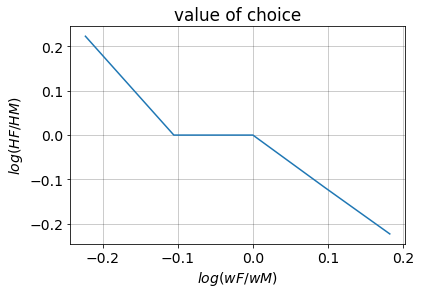

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

model = HouseholdSpecializationModelClass()

wF_values = [0.8, 0.9, 1.0, 1.1, 1.2]
log_wF_wM = np.log(np.array(wF_values) / model.par.wM)

for i, wF in enumerate(wF_values):
    model.par.wF = wF
    opt = model.solve_discrete()
    model.sol.LM_vec[i], model.sol.HM_vec[i], model.sol.LF_vec[i], model.sol.HF_vec[i] = opt.LM, opt.HM, opt.LF, opt.HF

log_HF_HM = np.log(model.sol.HF_vec / model.sol.HM_vec)

# Predefine options for all plots
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 14})

# a. create the figure
fig = plt.figure()

# b. left plot
ax = fig.add_subplot(1,1,1)

ax.plot(log_wF_wM,log_HF_HM)

ax.set_title('value of choice')
ax.set_xlabel('$log(wF/wM)$')
ax.set_ylabel('$log(HF/HM)$');